For this project, I have used CRISP-DM framework in its data science process

## 1. BUSINESS UNDERSTANDING

### 1.1 The audience

The Target audience for this project are:
* Movie lovers

* Movie studios/distributors

* E-commerce business selling movies

### 1.2 Business Problem
The audience is in need of a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

### 1.3 Business Objectives
The objective of this project is to develop a model to:
* Develop a machine learning model that delivers personalized top 5 movie recommendations to users.

* Base recommendations on individual movie ratings provided by users.

* Achieve a more engaging and profitable recommendation system for the stakeholders.

* Boost user satisfaction through personalized movie recommendations.

* Expose movie users to new and diverse content, expanding their horizons and introducing them to items they might have overlooked.

### 1.4 Metrics of success

### Similarity Metrics to use

**Pearson Correlation**: Is a commonly used method for computing similarity. It ranges from [-1, 1] and it represents the linear correlation between two vectors. A correlation value of 0 represents no relationship, -1 represents a high negative correlation and +1 represents high positive correlation. This similarity metric only takes into account those items that are rated by both individuals.

### $$ \text{pearson correlation}(u,v) = \frac{\sum_{i \in I_{uv}}{(r_{ui}- \mu_{u})*(r_{vi}- \mu_{v})}}{\sqrt{\sum_{i \in I_{uv} }{(r_{ui}-\mu_{u})^{2}  }}  * \sqrt{\sum_{i \in I_{uv} }{(r_{vi}-\mu_{v})^{2}  }}} $$


**Cosine Similarity**: Determines how vectors are related to each other by measuring the cosine angle between two vectors. The value also ranges from [-1, 1], with -1 meaning that the two vectors are diametrically opposed, 0 meaning the two vectors are perpendicular to one another, and 1 meaning that the vectors are the same. Here is the formula in the context of user similarity:

### $$ \text{cosine similarity}(u,v) = \frac{\sum_{i \in I_{uv}}{r_{ui}*r_{vi}}}{\sqrt{\sum_{i \in I_{uv} }{r_{ui}^{2}  }}  * \sqrt{\sum_{i \in I_{uv} }{r_{ui}^{2}  }}} $$

where $u$ is a user and $v$ is another user being compared to $u$. $i$ represents each item being rated. $I$ is the entire item set.



### SVD and Recommendations

With SVD, we turn the recommendation problem into an __Optimization__ problem that deals with how good we are in predicting the rating for items given a user. One common metric to achieve such optimization is __Root Mean Square Error (RMSE)__. A lower RMSE is indicative of improved performance and vice versa. RMSE is minimized on the known entries in the utility matrix. SVD has a great property that it has the minimal reconstruction Sum of Square Error (SSE); therefore, it is also commonly used in dimensionality reduction. Below is the formula to achieve this:

$$min_{UV\Sigma}\sum_{i,j∈A}(A_{ij} - [UV\Sigma^T]_{ij})^2$$


RMSE and SSE are monotonically related. This means that the lower the SSE, the lower the RMSE. With the convenient property of SVD that it minimizes SSE, we know that it also minimizes RMSE. Thus, SVD is a great tool for this optimization problem. To predict the unseen item for a user, we simply multiply $U$, $V$, and $\Sigma^{T}$.

#### 1.5 Data Source

The data was sourced from https://grouplens.org/datasets/movielens/latest/ and has files named links.csv, movies.csv, ratings.csv and tags.csv. 

In [3]:
# import relevant libraries
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import torch
import matplotlib.pyplot as plt
from IPython.display import display
from surprise import Dataset, Reader,SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split,GridSearchCV
from surprise.prediction_algorithms import knns, SVD
from surprise.similarities import cosine, msd, pearson
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from scipy.stats import pearsonr





## 2. DATA UNDERSTANDING

### 2.1 Data Description and Quality

#### Loading the dataset -  I will load the dataset into a pandas DataFrame which will facilitate easy manipulation and analysis.

In [4]:
# Path to the zip file
zip_file_path = 'Data/ml-latest-small.zip'

# Path to the extraction folder
extracted_files_path = 'Data'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)

# Paths to csv files
file1 = 'Data/ml-latest-small/links.csv'
file2 = 'Data/ml-latest-small/movies.csv'
file3 = 'Data/ml-latest-small/ratings.csv'
file4='Data/ml-latest-small/tags.csv'

# Read the CSV files into dataframes
df_links= pd.read_csv(file1)
df_movies= pd.read_csv(file2)
df_ratings= pd.read_csv(file3)
df_tags= pd.read_csv(file4)

# Display the first few rows of each dataframe
print("df_links:")
print(df_links.head(3))

print("df_movies:")
print(df_movies.head(3))

print("df_ratings:")
print(df_ratings.head(3))

print("df_tags:")
print(df_tags.head(3))



df_links:
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
df_movies:
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
df_ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
df_tags:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992


- Movie ids are consistent between ratings.csv, tags.csv, movies.csv, and links.csv 

### Next, I will make steps to understand the dataset before moving on to the data cleaning and transformation phases. The steps include reviewing the structure and the content of the dataset

In [5]:
# Print the shapes of each dataframe
print("df_links shape:", df_links.shape)

print("\ndf_movies shape:", df_movies.shape)

print("\ndf_ratings shape:", df_ratings.shape)

print("\ndf_tags shape:", df_tags.shape)


df_links shape: (9742, 3)

df_movies shape: (9742, 3)

df_ratings shape: (100836, 4)

df_tags shape: (3683, 4)


### timestamp is not relevant to our model and it can be removed

In [6]:
df_tags_final = df_tags.drop(['timestamp'], axis=1)
df_ratings_final = df_ratings.drop(['timestamp'], axis=1)
print(df_tags_final.head())
print(df_ratings_final.head())

   userId  movieId              tag
0       2    60756            funny
1       2    60756  Highly quotable
2       2    60756     will ferrell
3       2    89774     Boxing story
4       2    89774              MMA
   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


### Merge datasets

#### Since our model is reliant on movie ratings to provides top 5 movie recommendations to a user, i have merged df_movies to the df_rating dataset so as to include the movie title and genre to the dataset. I will also include movie tag from df_tags to the df_rating. This is meant to provide more information about the movies the model will recommend.

In [7]:
# Merge df_rating and df_movies on movieId
df_merged = pd.merge(df_ratings_final, df_movies, on='movieId')

# Merge the resulting dataframe with df_tags on movieId
df_final = pd.merge(df_merged, df_tags_final, on='movieId')

# Display the first 5 rows of the final merged dataframe
print(df_final.head())


   userId_x  movieId  rating                    title  \
0         1        1     4.0         Toy Story (1995)   
1         1        1     4.0         Toy Story (1995)   
2         1        1     4.0         Toy Story (1995)   
3         1        3     4.0  Grumpier Old Men (1995)   
4         1        3     4.0  Grumpier Old Men (1995)   

                                        genres  userId_y    tag  
0  Adventure|Animation|Children|Comedy|Fantasy       336  pixar  
1  Adventure|Animation|Children|Comedy|Fantasy       474  pixar  
2  Adventure|Animation|Children|Comedy|Fantasy       567    fun  
3                               Comedy|Romance       289  moldy  
4                               Comedy|Romance       289    old  


In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233213 entries, 0 to 233212
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userId_x  233213 non-null  int64  
 1   movieId   233213 non-null  int64  
 2   rating    233213 non-null  float64
 3   title     233213 non-null  object 
 4   genres    233213 non-null  object 
 5   userId_y  233213 non-null  int64  
 6   tag       233213 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 12.5+ MB


#### The merged dataset has 233,213 rows and 7 columns. There are columns that have been duplicated for example userId that need clean up

#### I am going to clean columns with same name after merging by dropping one of them.

In [9]:
df_final = df_final.drop(columns=['userId_y'])
df_final.head()

,userId_x,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,old


#### Rename columns with appended suffix after merging datasets

In [10]:
df_final.rename(columns={'userId_x': 'userId'}, inplace=True)
df_final.head()


,userId,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,old


In [11]:
df_final.shape

(233213, 6)

#### I will use isna() to check for null values

In [12]:
df_final.isna().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
tag        0
dtype: int64

#### I checked for duplicate rows to enable me clean the dataset

In [13]:
# Check for duplicate rows
duplicates = df_final[df_final.duplicated()]
print("Duplicate Rows:")
duplicates.info()


Duplicate Rows:
<class 'pandas.core.frame.DataFrame'>
Index: 13807 entries, 1 to 233175
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   13807 non-null  int64  
 1   movieId  13807 non-null  int64  
 2   rating   13807 non-null  float64
 3   title    13807 non-null  object 
 4   genres   13807 non-null  object 
 5   tag      13807 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 755.1+ KB


### The merged dataset has 13807 duplicate rows that need clean up

In [14]:
# Remove duplicate rows
df_final_clean = df_final.drop_duplicates()
df_final_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219406 entries, 0 to 233212
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   219406 non-null  int64  
 1   movieId  219406 non-null  int64  
 2   rating   219406 non-null  float64
 3   title    219406 non-null  object 
 4   genres   219406 non-null  object 
 5   tag      219406 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 11.7+ MB


### Generating summary statistics will help get insights on the dataset distribution

In [15]:
df_final_clean.describe()

,userId,movieId,rating
count,219406.000000,219406.000000,219406.000000
mean,309.827945,12442.645949,3.959869
std,178.333073,28443.938687,0.971216
min,1.000000,1.000000,0.500000
25%,157.000000,296.000000,3.500000
50%,309.000000,1198.000000,4.000000
75%,460.000000,4639.000000,5.000000
max,610.000000,193565.000000,5.000000


### 2.2 Exploratory Data Analysis (EDA)

#### Distribution of Movie Ratings

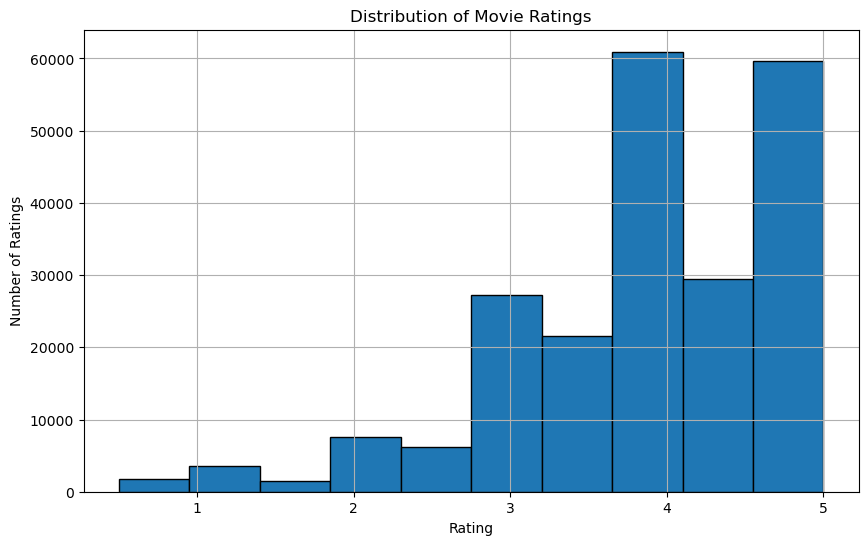

In [16]:
# Distribution of movie ratings
plt.figure(figsize=(10, 6))
df_final_clean['rating'].hist(bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Movie Ratings')
plt.show()

# Most and least frequently rated movies
rating_counts = df_final_clean.groupby('movieId').size().reset_index(name='count')
most_rated = rating_counts.sort_values(by='count', ascending=False).head(10)
least_rated = rating_counts.sort_values(by='count', ascending=True).head(10)


### Ascertain top 10 movies by number of 5-staff ratings

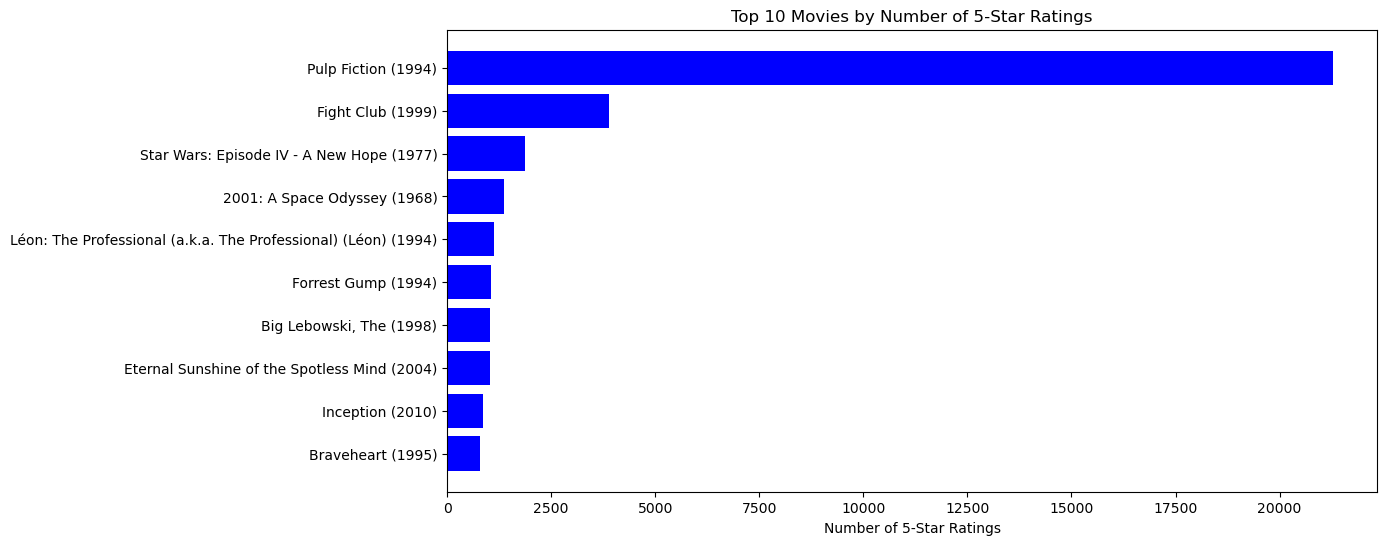

In [ ]:
# Filter ratings for score of 5
high_ratings = df_final_clean[df_final_clean['rating'] == 5.0]

# Count the number of 5-star ratings per movie
top_movies = high_ratings.groupby('movieId').size().reset_index(name='count')

# Merge with movie titles
top_movies = top_movies.merge(df_final_clean[['movieId', 'title']].drop_duplicates(), on='movieId')

# Get the top 10 movies
top_10_movies = top_movies.sort_values(by='count', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_10_movies['title'], top_10_movies['count'], color='skyblue')
plt.xlabel('Number of 5-Star Ratings')
plt.title('Top 10 Movies by Number of 5-Star Ratings')
plt.gca().invert_yaxis()
plt.show()


#### Distribution of Average Ratings per User

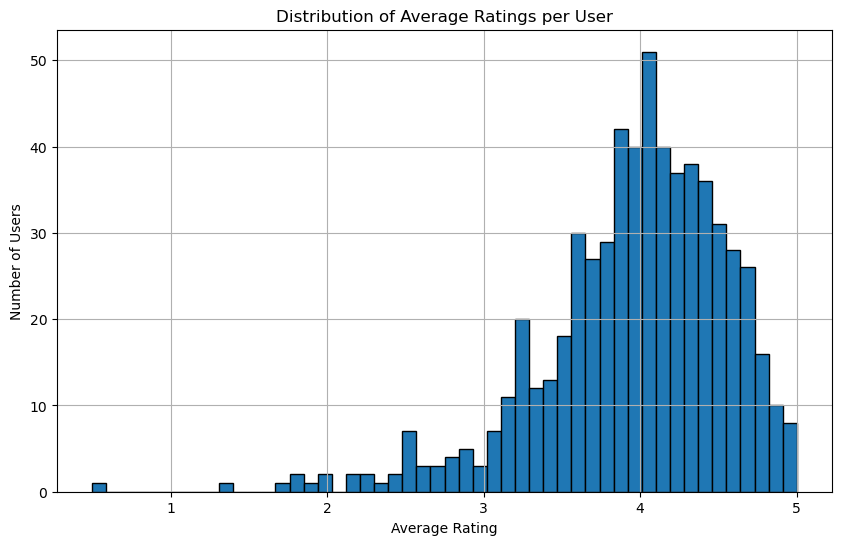

In [18]:
avg_user_ratings = df_final_clean.groupby('userId')['rating'].mean()
plt.figure(figsize=(10, 6))
avg_user_ratings.hist(bins=50, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.title('Distribution of Average Ratings per User')
plt.show()


#### Tag Analysis : Most Frequently Used Movie Tag

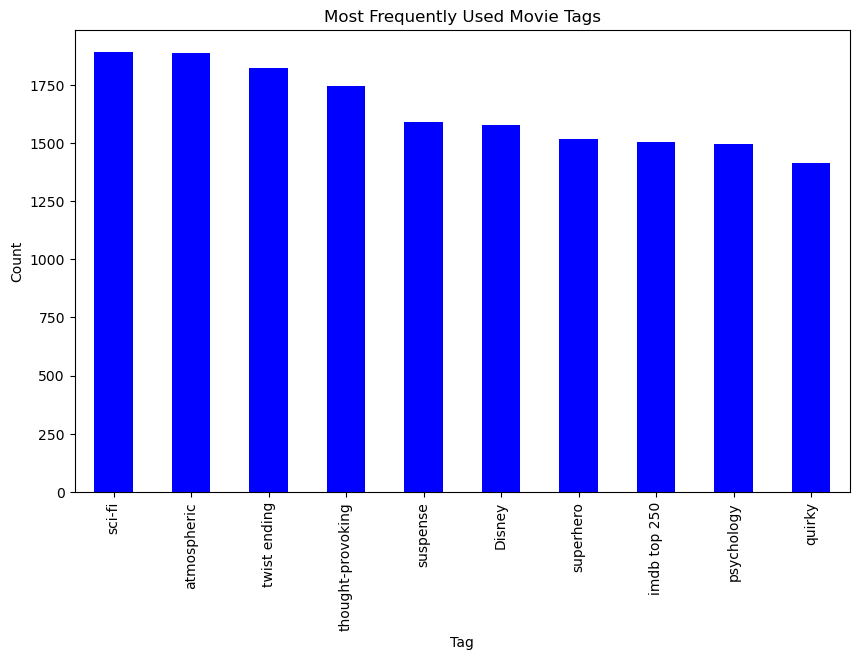

In [ ]:
# Most frequently used tags
tag_counts = df_final_clean['tag'].value_counts().head(10)

# Plotting the most frequently used tags
plt.figure(figsize=(10, 6))
tag_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Most Frequently Used Movie Tags')
plt.show()


#### Genre analysis : Most Popular Movie Genres

C:\Users\HP\AppData\Local\Temp\ipykernel_26512\3826325753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_clean['genres'] = df_final_clean['genres'].str.split('|')


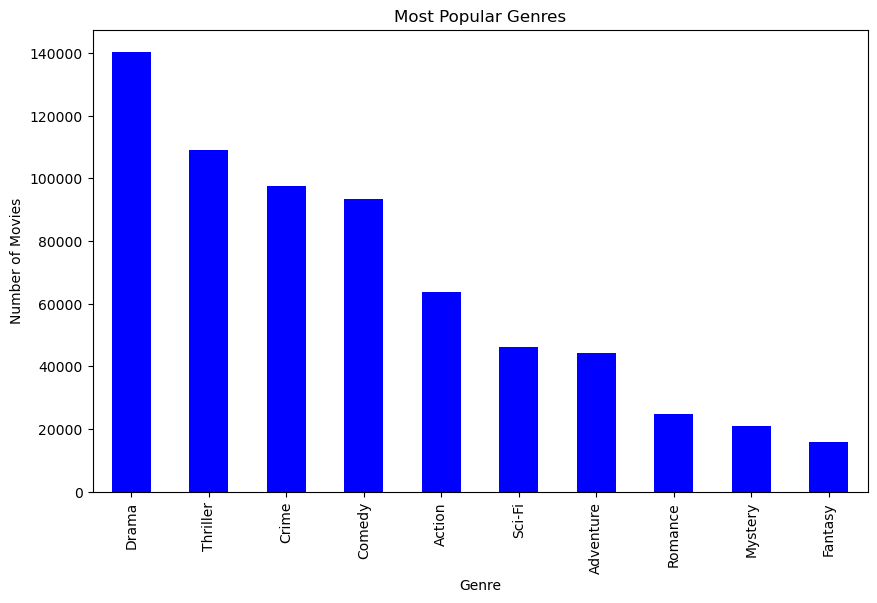

In [ ]:
# Splitting genres
df_final_clean['genres'] = df_final_clean['genres'].str.split('|')
genre_counts = df_final_clean.explode('genres')['genres'].value_counts()

# Most and least popular genres
most_popular_genres = genre_counts.head(10)
least_popular_genres = genre_counts.tail(10)

# Plotting the most popular genres
plt.figure(figsize=(10, 6))
most_popular_genres.plot(kind='bar', color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Most Popular Genres')
plt.show()


In [21]:
df_final_clean.head()

,userId,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",pixar
2,1,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",fun
3,1,3,4.0,Grumpier Old Men (1995),"[Comedy, Romance]",moldy
4,1,3,4.0,Grumpier Old Men (1995),"[Comedy, Romance]",old
5,1,47,5.0,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",mystery


In [22]:
numberOf_movies_voted_by_user = pd.DataFrame(df_final_clean.groupby('userId')['rating'].agg('count'))     
numberOf_movies_voted_by_user.reset_index(level = 0,inplace = True)
numberOf_movies_voted_by_user.head()

,userId,rating
0,1,558
1,2,128
2,3,27
3,4,543
4,5,267


Text(0, 0.5, 'Number Of Movies rated by user')

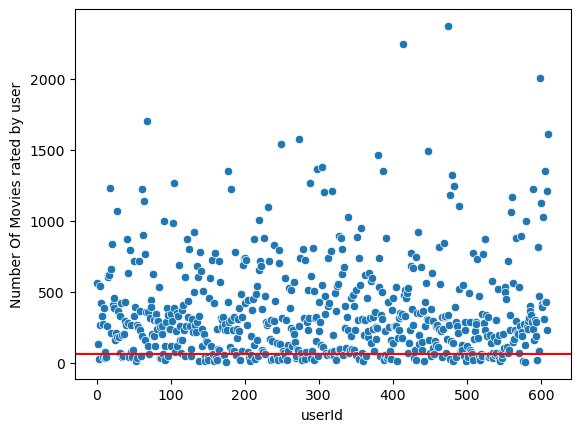

In [23]:
plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'userId', data = numberOf_movies_voted_by_user)
plt.axhline(y=60,color='r')
plt.ylabel('Number Of Movies rated by user')

## 3. DATA PREPARATION

#### Get to know the maximum rating

#### Surprise is a Python scikit for recommender systems. Surpirse library will need a rating scale from the dataset.

In [24]:
# Establishing the scale

# Establishing the minimum rating
min_rating = df_final_clean['rating'].min()
print(f"The minimum rating is: {min_rating}")

# Establishing the maximum rating
max_rating = df_final_clean['rating'].max()
print(f"The maximum rating is: {max_rating}")


The minimum rating is: 0.5
The maximum rating is: 5.0


- Ratings are made on a 5-star scale (0.5 stars - 5.0 stars).

#### I prepared data in a format compatible with surprise by use of a reader

In [25]:
# Define the rating scale (e.g., 0.5 to 5.0)
reader = Reader(rating_scale=(0.5, 5.0))

# Convert the DataFrame to a Surprise dataset
data = Dataset.load_from_df(df_final_clean[["userId", "movieId", "rating"]], reader)

### Split the dataset to training and testing sets

In [26]:
# Split the dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## 4. MODEL & EVALUATION

### Determining the best model 

#### I will use different models and see which ones perform best. For consistency, I will use RMSE to evaluate models. 

#### When evaluating models with Root Mean Squared Error (RMSE), a lower value is preferable. RMSE quantifies the average error magnitude between predicted and actual values, emphasizing larger Therefore, a lower RMSE signifies that the model's predictions are more accurate, indicating superior model performance.



### i. Collaborative Filtering with Singular Value Decomposition (SVD)

Collaborative filtering is a recommendation technique that analyzes a user’s behavior and compares it to the behavior of other users in the database. It leverages the collective history of all users to shape and enhance the recommendation algorithm. Singular-Value Decomposition or SVD is a common and widely used matrix decomposition method. All matrices are able to be factored using an SVD, which makes it more stable than other methods, such as the eigendecomposition.

### a. SVD model

In [27]:
# Train the model
svd=SVD()
svd.fit(trainset)

In [28]:
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.3956
0.39556415191590927


### b. Tuned SVD

In [29]:
# Defining the parameter grid
param_grid = {
    'n_factors': [700,800],
    'n_epochs': [40,60],
    'lr_all': [0.12, 0.16],
    'reg_all': [0.00001, 0.0001]
}

In [30]:
# Gridsearch with SVD
GridSearch = GridSearchCV(SVD, param_grid=param_grid, cv=2, n_jobs=-1, joblib_verbose=0)
GridSearch.fit(data)


In [31]:
# Print the best parameters
print("Best parameters:", GridSearch.best_params['rmse'])

Best parameters: {'n_factors': 800, 'n_epochs': 60, 'lr_all': 0.12, 'reg_all': 1e-05}


In [32]:
# Initialize the SVD algorithm with the best parameters, fit the model, make predictions and evaluate mode accuracy
svd_tuned = GridSearch.best_estimator['rmse']
svd_tuned.fit(trainset)
predictions = svd_tuned.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.2941
0.29406845115043323


In [33]:

# svd_tuned = SVD(n_factors=800, n_epochs=40, lr_all=0.12, reg_all=0.00001)
# svd_tuned.fit(trainset)
# predictions = svd_tuned.test(testset)
# print(accuracy.rmse(predictions))

#### The RMSE for the tuned SVD model is much lower than the initial model, signifying the tuned model to be having more accuracy in prediction that the later, hence a superior mode.

### ii. Content-Based Filtering Model

#### Content-based filtering is a technique for making recommendations by suggesting items that are similar to those a user has previously enjoyed.

In [34]:
rating_matrix = df_final_clean.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)

def compute_similarity(matrix, method='cosine'):
    if method == 'cosine':
        return cosine_similarity(matrix, matrix)
    elif method == 'euclidean':
        return euclidean_distances(matrix, matrix)
    elif method == 'pearson':
        return pearson_correlation(matrix)
    else:
        raise ValueError("Unknown similarity method")

def pearson_correlation(matrix):
    correlation_matrix = np.zeros((matrix.shape[0], matrix.shape[0]))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[0]):
            correlation_matrix[i, j] = pearsonr(matrix[i], matrix[j])[0]
    return correlation_matrix

def get_content_based_recommendations(movie_id, similarity_method='cosine'):
    sim_matrix = compute_similarity(rating_matrix.values, method=similarity_method)
    idx = rating_matrix.index.tolist().index(movie_id)
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    recommendations = df_final_clean[df_final_clean['movieId'].isin(rating_matrix.index[movie_indices])]
    movie_titles_ratings = recommendations.groupby('movieId').agg({'title': 'first', 'rating': 'mean'}).reset_index()
    return movie_titles_ratings


### iii. Hybrid Approach

In [35]:
def get_hybrid_recommendations(user_id, movie_id, svd_tuned, df_final_clean, similarity_method='cosine'):
    all_movie_ids = df_final_clean['movieId'].unique()
    user_rated_movie_ids = df_final_clean[df_final_clean['userId'] == user_id]['movieId'].unique()
    movie_ids_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movie_ids]
    predictions = [svd_tuned.predict(user_id, movie_id) for movie_id in movie_ids_to_predict]
    top_5_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]
    top_5_movie_ids_cf = [pred.iid for pred in top_5_predictions]
    cf_recommendations = df_final_clean[df_final_clean['movieId'].isin(top_5_movie_ids_cf)]
    cf_movie_titles_ratings = cf_recommendations.groupby('movieId').agg({'title': 'first', 'rating': 'mean'}).reset_index()
    
    cbf_movie_titles_ratings = get_content_based_recommendations(movie_id, similarity_method=similarity_method)
    
    combined_recommendations = pd.concat([cf_movie_titles_ratings, cbf_movie_titles_ratings]).drop_duplicates(subset=['title']).head(5)
    
    return combined_recommendations


## 5. Making recommendations

#### i. Collaborative Filtering (SVD) Recommendations

In [ ]:
# Usage of Collaborative Filtering (SVD)
def get_svd_recommendations(user_id, svd_tuned, df_final_clean):
    all_movie_ids = df_final_clean['movieId'].unique()
    user_rated_movie_ids = df_final_clean[df_final_clean['userId'] == user_id]['movieId'].unique()
    movie_ids_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movie_ids]
    predictions = [svd_tuned.predict(user_id, movie_id) for movie_id in movie_ids_to_predict]
    top_5_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]
    top_5_movie_info = [(pred.iid, pred.est) for pred in top_5_predictions]
    top_5_movie_titles_ratings = [(df_final_clean[df_final_clean['movieId'] == movie_id]['title'].values[0], rating) for movie_id, rating in top_5_movie_info]
    for i, (title, rating) in enumerate(top_5_movie_titles_ratings, 1):
        print(f"{i}. {title} - Rating: {rating:.2f}")

user_id = 1 
print("Recommendations using Collaborative Filtering (SVD):")
get_svd_recommendations(user_id, svd_tuned, df_final_clean)


Recommendations using Collaborative Filtering (SVD):
1. Shawshank Redemption, The (1994) - Rating: 5.00
2. Lone Star (1996) - Rating: 5.00
3. Waiting for Guffman (1996) - Rating: 5.00
4. Lord of the Rings: The Fellowship of the Ring, The (2001) - Rating: 5.00
5. Beautiful Mind, A (2001) - Rating: 5.00


#### ii. Content-Based Filtering Recommendations

In [ ]:
# Usage OF content-based recommendations
print("Recommendations using Content_Based Filtering:")
get_content_based_recommendations(1, similarity_method='cosine')



Recommendations using Content_Based Filtering:


,movieId,title,rating
0,260,Star Wars: Episode IV - A New Hope (1977),4.231076
1,356,Forrest Gump (1994),4.164134
2,480,Jurassic Park (1993),3.750000
3,780,Independence Day (a.k.a. ID4) (1996),3.445545
4,3114,Toy Story 2 (1999),3.860825


#### iii. Hybrid Approach Recommendations

In [ ]:
# Usage OF Hybrid Approach recommendations
user_id = 1  
movie_id = 1  
hybrid_recommendations = get_hybrid_recommendations(user_id, movie_id, svd_tuned, df_final_clean, similarity_method='cosine')
print("Recommendations using Hybrid Approach:")
for i, row in hybrid_recommendations.iterrows():
    print(f"{i+1}. {row['title']} - Average Rating: {row['rating']:.2f}")


Recommendations using Hybrid Approach:
1. Shawshank Redemption, The (1994) - Average Rating: 4.43
2. Lone Star (1996) - Average Rating: 4.16
3. Waiting for Guffman (1996) - Average Rating: 3.88
4. Lord of the Rings: The Fellowship of the Ring, The (2001) - Average Rating: 4.11
5. Beautiful Mind, A (2001) - Average Rating: 4.00


### Conclusion

### Findings 

#### Accuracy and Predictions:

* The SVD model gives extremely high predicted ratings (all 5.00), indicating strong confidence in these recommendations based on user rating patterns.

* Content-Based Filtering method provides slightly varied predicted ratings, reflecting the degree of similarity between movies based on their features.

* The hybrid approach shows a more balanced set of average ratings, considering both user-item interactions (collaborative filtering) and item features (content-based filtering).

#### Recommendation Overlap:

* SVD and Hybrid Approach: Both models recommend "Shawshank Redemption, The (1994)", "Waiting for Guffman (1996)", "Lord of the Rings: The Fellowship of the Ring, The (2001)", "Lord of the Rings: The Two Towers, The (2002)", and "Whiplash (2014)", showing a strong preference for these movies based on user behavior.

* Content-Based Filtering: This method provides different recommendations, including "Star Wars: Episode IV - A New Hope (1977)", "Forrest Gump (1994)", "Jurassic Park (1993)", "Independence Day (1996)", and "Toy Story 2 (1999)".

#### Diversity of Recommendations:

* The SVD model focuses on a specific set of movies with maximum predicted ratings, which might lack diversity.

* Content-Based Filtering offers a more diverse set of recommendations based on the similarity of movie features, potentially exposing users to a wider range of movies.

* Hybrid Approach combines the strengths of both collaborative filtering and content-based filtering, providing a balanced and diverse set of movie recommendations.

### Overall,

* SVD excels in capturing user preferences based on historical ratings.

* Content-Based Filtering identifies similar movies based on features and content, offering diversity.

* Hybrid Approach balances the strengths of both methods, providing personalized and diverse recommendations.

### Recommendation

* Consider implementing other models like Neural Collaborative Filtering (NCF) for better performance.

* Integrate more features like genres and tags to enhance the recommendation system.

### Insights for next steps

* I would wish to try other other deep learning architectures.